In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import anndata as ad
import time
import matplotlib.pyplot as plt
from pathlib import Path
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
import scanpy as sc
import squidpy as sq
import seaborn as sns

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
download_base = Path("/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/abc_atlas")
abc_cache = AbcProjectCache.from_cache_dir(download_base)

#to see current release 
abc_cache.current_manifest

'releases/20250131/manifest.json'

In [3]:
datasets = ['Zhuang-ABCA-3']
example_section = {'Zhuang-ABCA-3': 'Zhuang-ABCA-3.010'}

In [4]:
cell = {}

for d in datasets :

    cell[d] = abc_cache.get_metadata_dataframe(
        directory=d,
        file_name='cell_metadata',
        dtype={"cell_label": str}
    )
    cell[d].set_index('cell_label', inplace=True)
    
    sdf = cell[d].groupby('brain_section_label')
    
    print(d,":","Number of cells = ", len(cell[d]), ", ", "Number of sections =", len(sdf))

Zhuang-ABCA-3 : Number of cells =  1585843 ,  Number of sections = 23


In [5]:
# Cluster annotation 
# Read in the pivot table 
# from the “cluster annotation tutorial” to associate each cell with terms at 
# each cell type classification level and the corresponding color.
cluster_details = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_pivoted',
    keep_default_na=False
)
cluster_details.set_index('cluster_alias', inplace=True)

cluster_colors = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_color',
)
cluster_colors.set_index('cluster_alias', inplace=True)

In [6]:
cell_extended = {}

for d in datasets :
    cell_extended[d] = cell[d].join(cluster_details, on='cluster_alias')
    cell_extended[d] = cell_extended[d].join(cluster_colors, on='cluster_alias')

In [7]:
# Gene panel

# All 4 datasets shares the same 1122 gene panel selected to enable faciliate the mapping to 
# transcriptomically defined cell types taxonomies. Each gene is uniquely identifier by an Ensembl ID. 
# It is best practice to gene identifier to for tracking and data interchange as gene symbols are not 
# unique and can change over time.

# Each row of the gene dataframe has Ensembl gene identifier, a gene symbol and name.
gene = abc_cache.get_metadata_dataframe(directory=datasets[0],
                                        file_name='gene')
gene.set_index('gene_identifier', inplace=True)
print("Number of genes = ", len(gene))
gene.head(5)

gene.csv: 100%|███████████████████████████████████████████████████████████████████| 84.7k/84.7k [00:00<00:00, 152kMB/s]

Number of genes =  1122


gene_symbol  \
gene_identifier                  
ENSMUSG00000024798        Htr7   
ENSMUSG00000042385        Gzmk   
ENSMUSG00000036198    Arhgap36   
ENSMUSG00000028780      Sema3c   
ENSMUSG00000015843        Rxrg   

                                                                 name  \
gene_identifier                                                         
ENSMUSG00000024798         5-hydroxytryptamine (serotonin) receptor 7   
ENSMUSG00000042385                                         granzyme K   
ENSMUSG00000036198                   Rho GTPase activating protein 36   
ENSMUSG00000028780  sema domain, immunoglobulin domain (Ig), short...   
ENSMUSG00000015843                          retinoid X receptor gamma   

                   mapped_ncbi_identifier  
gene_identifier                            
ENSMUSG00000024798         NCBIGene:15566  
ENSMUSG00000042385         NCBIGene:14945  
ENSMUSG00000036198         NCBIGene:75404  
ENSMUSG00000028780         NCBIGene:20348  
ENSMUSG00000015843         NCBIGene:20183

In [8]:
def subplot_section(ax, xx, yy, cc = None, val = None, cmap = None) :
    
    if cmap is not None :
        ax.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None :
        ax.scatter(xx, yy, s=0.5, color=cc, marker='.')
    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])

In [15]:
def plot_sections(cell_extended, example_section, cc = None, val = None, fig_width = 10, fig_height = 10, cmap = None) :
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(fig_width, fig_height)
    
    for i, d in enumerate(cell_extended):
        
        pred = (cell_extended[d]['brain_section_label'] == example_section[d])
        section = cell_extended[d][pred] 
        
        if cmap is not None :
            subplot_section( ax, section['x'], section['y'], val=section[val], cmap=cmap)
        elif cc is not None :
            subplot_section( ax, section['x'], section['y'], section[cc])
            
        ax.set_title(d)
        
    return fig, ax

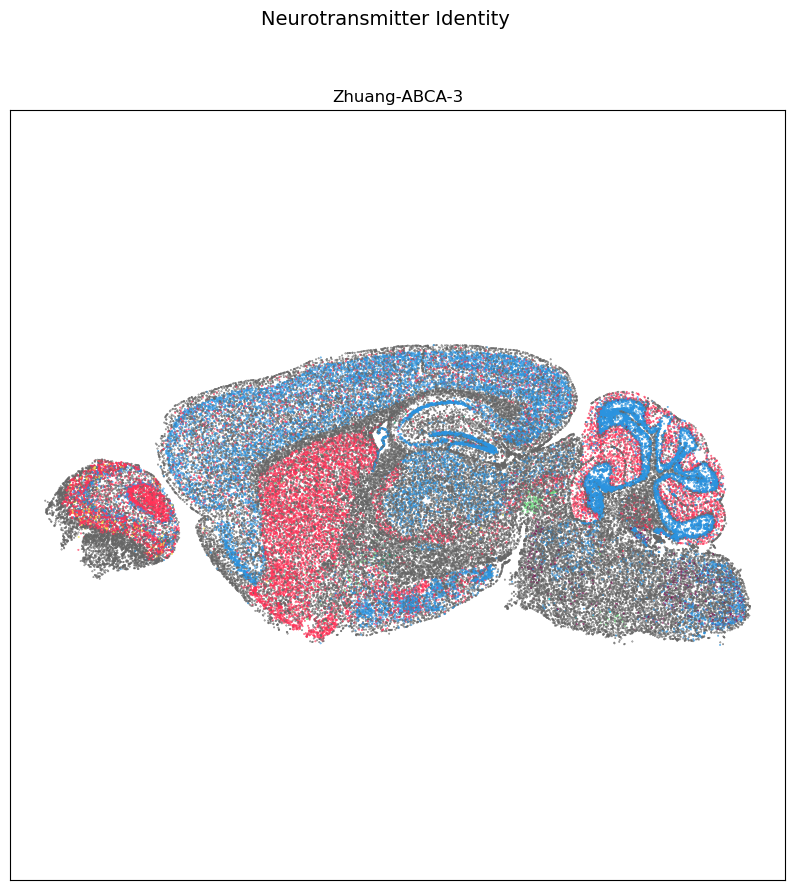

In [16]:
fig, ax = plot_sections(cell_extended, example_section, 'neurotransmitter_color')
res = fig.suptitle('Neurotransmitter Identity', fontsize=14)
plt.show()

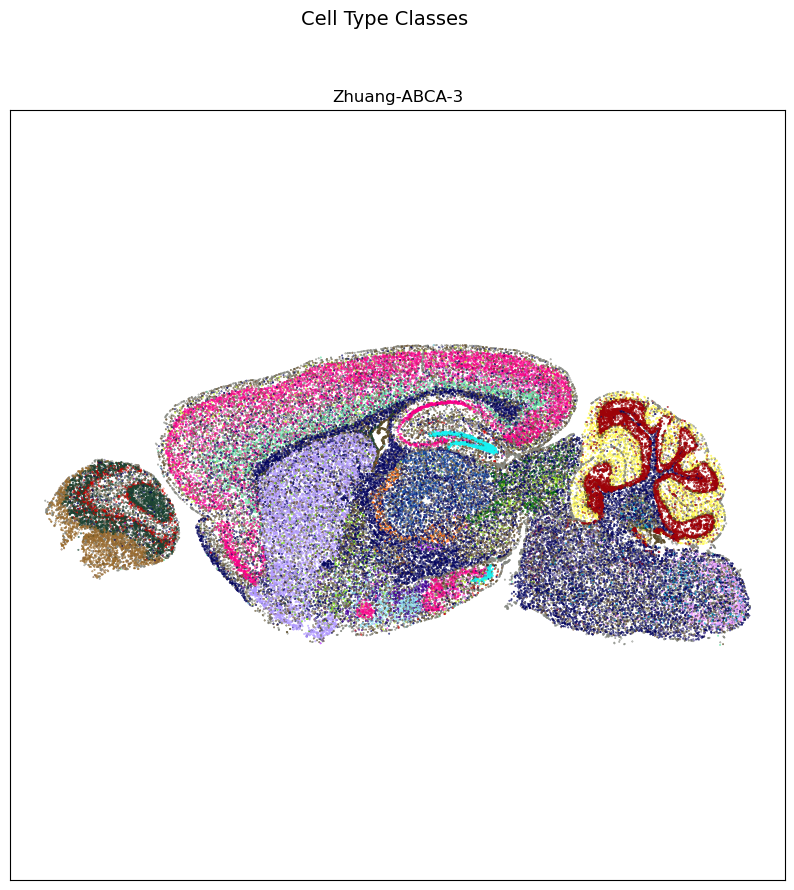

In [17]:
fig, ax = plot_sections(cell_extended, example_section, 'class_color')
res = fig.suptitle('Cell Type Classes', fontsize=14)
plt.show()

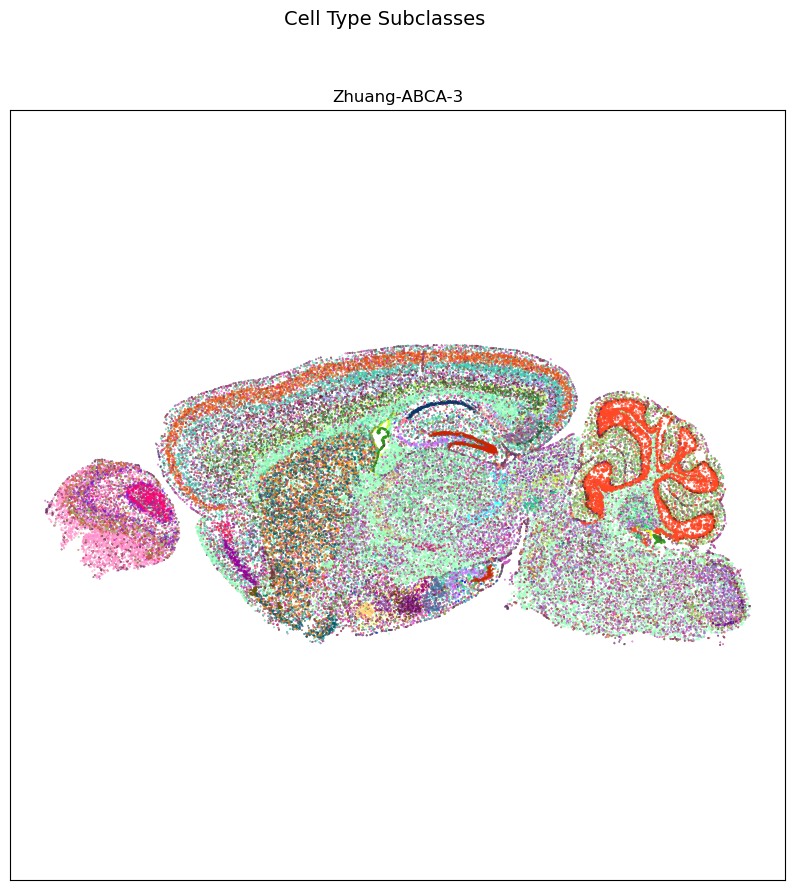

In [18]:
fig, ax = plot_sections(cell_extended, example_section, 'subclass_color')
res = fig.suptitle('Cell Type Subclasses', fontsize=14)
plt.show()

In [19]:
#annotation information: 
# CCF registration and parcellation annotation
# Each brain specimen has been registered to Allen CCFv3 atlas, resulting in an x, y, z coordinates and parcellation_index for each cell.
ccf_coordinates = {}

for d in datasets :

    ccf_coordinates[d] = abc_cache.get_metadata_dataframe(directory=f"{d}-CCF", file_name='ccf_coordinates')
    ccf_coordinates[d].set_index('cell_label', inplace=True)
    ccf_coordinates[d].rename(columns={'x': 'x_ccf',
                                       'y': 'y_ccf',
                                       'z': 'z_ccf'},
                              inplace=True)
    
    cell_extended[d] = cell_extended[d].join(ccf_coordinates[d], how='inner')

In [20]:
#Read in the pivot table from the “parcellation annotation tutorial” to associate each cell with terms at 
#each anatomical parcellation level and the corresponding color.
parcellation_annotation = abc_cache.get_metadata_dataframe(directory="Allen-CCF-2020",
                                                           file_name='parcellation_to_parcellation_term_membership_acronym')
parcellation_annotation.set_index('parcellation_index', inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]

parcellation_color = abc_cache.get_metadata_dataframe(directory="Allen-CCF-2020",
                                                      file_name='parcellation_to_parcellation_term_membership_color')
parcellation_color.set_index('parcellation_index', inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]

for d in datasets :
    cell_extended[d] = cell_extended[d].join(parcellation_annotation, on='parcellation_index')
    cell_extended[d] = cell_extended[d].join(parcellation_color, on='parcellation_index')   

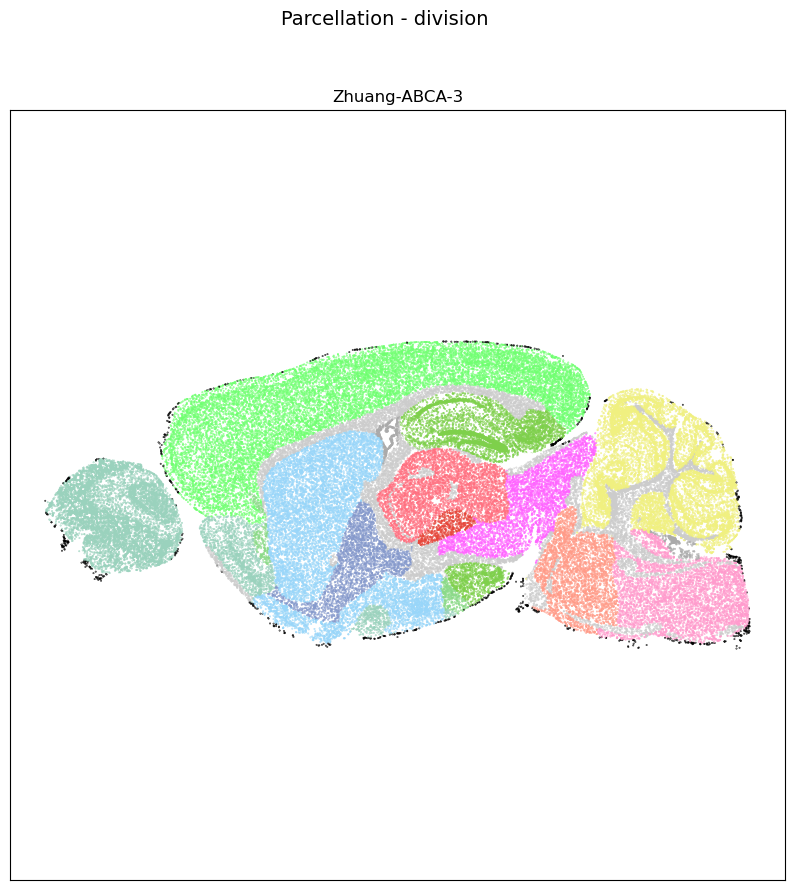

In [21]:
fig, ax = plot_sections(cell_extended, example_section, 'parcellation_division_color')
res = fig.suptitle('Parcellation - division', fontsize=14)
plt.show()

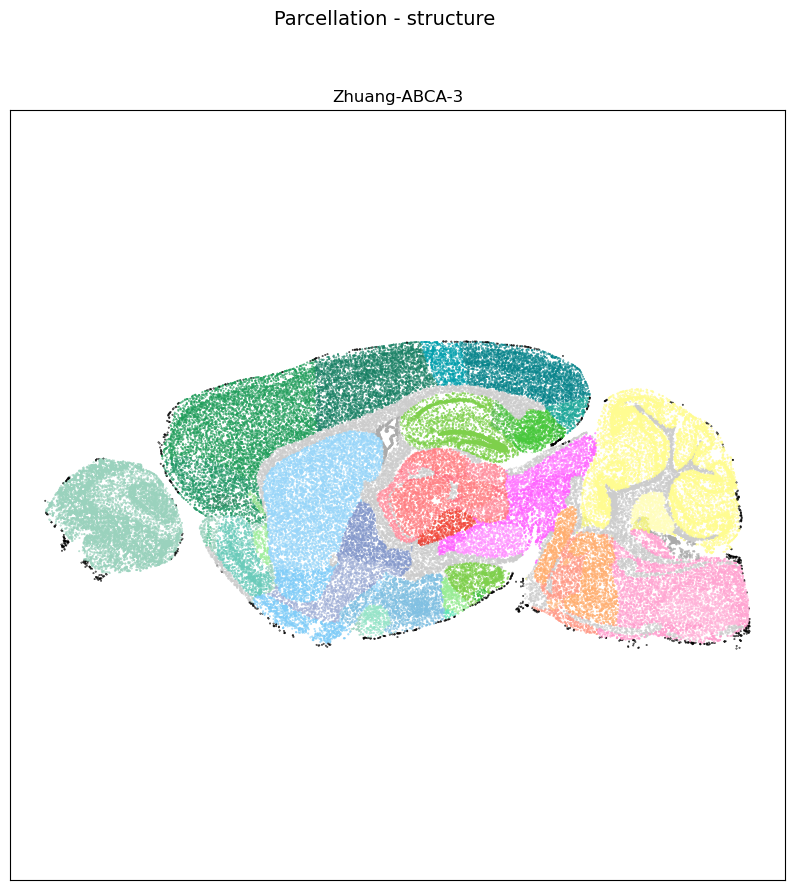

In [22]:
fig, ax = plot_sections(cell_extended, example_section, 'parcellation_structure_color')
res = fig.suptitle('Parcellation - structure', fontsize=14)
plt.show()

In [24]:
file=abc_cache.get_data_path(directory = 'Zhuang-ABCA-3',file_name = "Zhuang-ABCA-3/raw")
adata = ad.read_h5ad(file)

In [38]:
pred = cell_extended[d]['brain_section_label'] == example_section[d]
section = cell_extended[d][pred].copy()

In [27]:
section

brain_section_label  \
cell_label                                                    
248835065926710337774849466821708035608   Zhuang-ABCA-3.010   
113074106832432821184186051558459165277   Zhuang-ABCA-3.010   
161212280890616951303772083959691627186   Zhuang-ABCA-3.010   
165296441880712022068927545511068179250   Zhuang-ABCA-3.010   
177563812304744345042538684544834144745   Zhuang-ABCA-3.010   
...                                                     ...   
316556299089241537445234136802223004986   Zhuang-ABCA-3.010   
4063220135400382763801050419925113055     Zhuang-ABCA-3.010   
68740395668186805679540009737257338815    Zhuang-ABCA-3.010   
78630822304367885911312672938021300599    Zhuang-ABCA-3.010   
324867329290048264685751415924506498069   Zhuang-ABCA-3.010   

                                        feature_matrix_label    donor_label  \
cell_label                                                                    
248835065926710337774849466821708035608        Zhuang-ABCA-3  Zhuang-ABCA-3   
113074106832432821184186051558459165277        Zhuang-ABCA-3  Zhuang-ABCA-3   
161212280890616951303772083959691627186        Zhuang-ABCA-3  Zhuang-ABCA-3   
165296441880712022068927545511068179250        Zhuang-ABCA-3  Zhuang-ABCA-3   
177563812304744345042538684544834144745        Zhuang-ABCA-3  Zhuang-ABCA-3   
...                                                      ...            ...   
316556299089241537445234136802223004986        Zhuang-ABCA-3  Zhuang-ABCA-3   
4063220135400382763801050419925113055          Zhuang-ABCA-3  Zhuang-ABCA-3   
68740395668186805679540009737257338815         Zhuang-ABCA-3  Zhuang-ABCA-3   
78630822304367885911312672938021300599         Zhuang-ABCA-3  Zhuang-ABCA-3   
324867329290048264685751415924506498069        Zhuang-ABCA-3  Zhuang-ABCA-3   

                                        donor_genotype donor_sex  \
cell_label                                                         
248835065926710337774849466821708035608          wt/wt         M   
113074106832432821184186051558459165277          wt/wt         M   
161212280890616951303772083959691627186          wt/wt         M   
165296441880712022068927545511068179250          wt/wt         M   
177563812304744345042538684544834144745          wt/wt         M   
...                                                ...       ...   
316556299089241537445234136802223004986          wt/wt         M   
4063220135400382763801050419925113055            wt/wt         M   
68740395668186805679540009737257338815           wt/wt         M   
78630822304367885911312672938021300599           wt/wt         M   
324867329290048264685751415924506498069          wt/wt         M   

                                         cluster_alias          x         y  \
cell_label                                                                    
248835065926710337774849466821708035608           5254  13.349085  3.088609   
113074106832432821184186051558459165277           4167  13.380944  3.137705   
161212280890616951303772083959691627186           4170  13.355586  3.161539   
165296441880712022068927545511068179250           4170  13.352602  3.224970   
177563812304744345042538684544834144745           5254  13.350518  3.109921   
...                                                ...        ...       ...   
316556299089241537445234136802223004986           5261  -0.231301  4.117361   
4063220135400382763801050419925113055             5260  -0.242200  4.143363   
68740395668186805679540009737257338815            5260  -0.243181  4.118508   
78630822304367885911312672938021300599            5260  -0.254259  4.182863   
324867329290048264685751415924506498069           5258  -0.267359  3.948282   

                                                z  subclass_confidence_score  \
cell_label                                                                     
248835065926710337774849466821708035608  3.681075                   0.999975   
113074106832432821184186051558459165277

In [39]:
subset_indices = section.index

# Subset the AnnData object
adata_subset = adata[subset_indices, :].copy()
adata_subset.obs = section
#add the coords to the correct place: 
centroids = adata_subset.obs[['x', 'y']].to_numpy()
adata_subset.obsm['spatial'] = centroids
adata_subset

AnnData object with n_obs × n_vars = 81464 × 1122
    obs: 'brain_section_label', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'cluster_alias', 'x', 'y', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'abc_sample_id', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_index', 'parcellation_organ', 'parcellation_category', 'parcellation_division', 'parcellation_structure', 'parcellation_substructure', 'parcellation_organ_color', 'parcellation_category_color', 'parcellation_division_color', 'parcellation_structure_color', 'parcellation_substructure_color'
    var: 'gene_symbol'
    obsm: 'spatial'

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


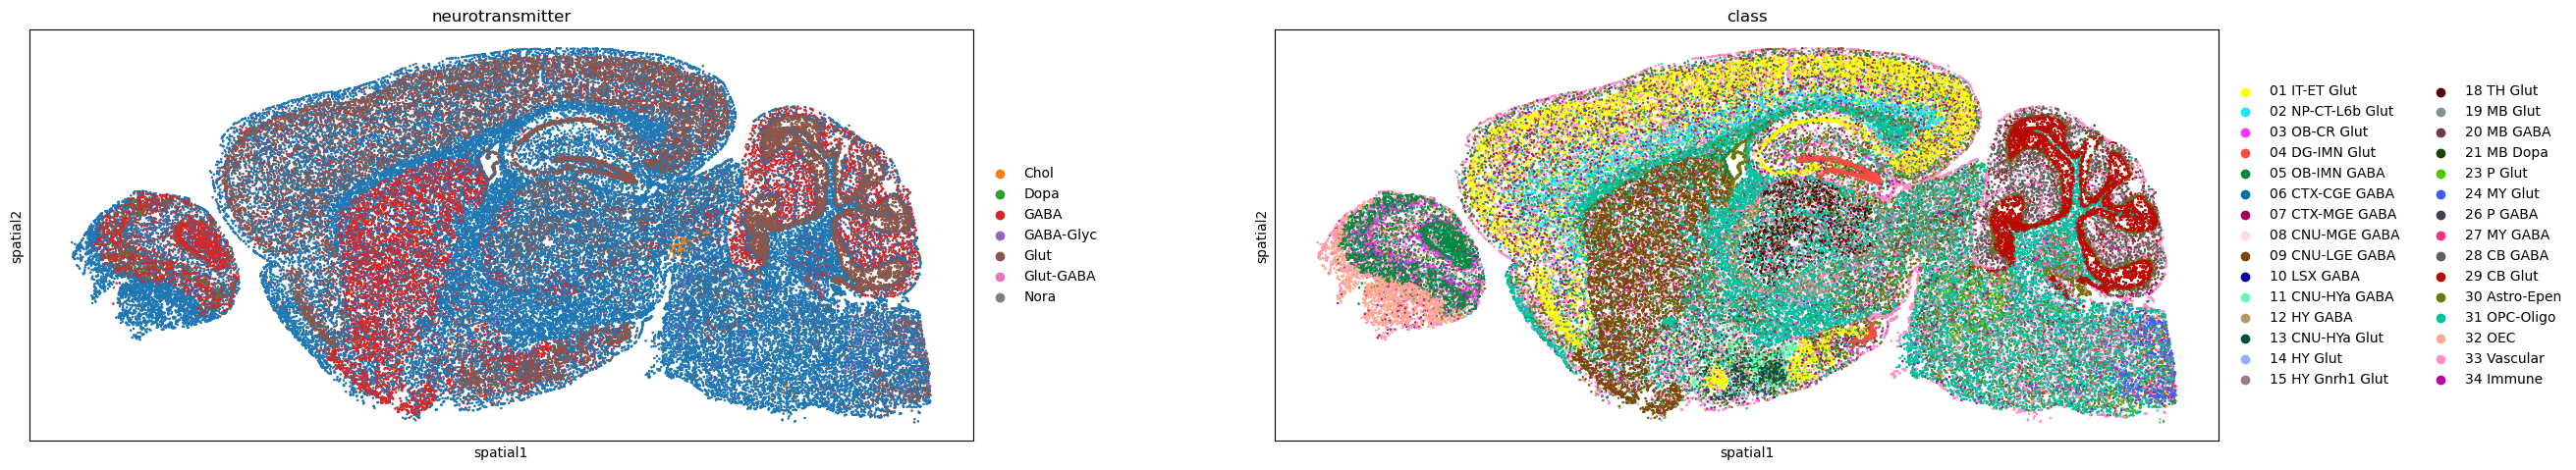

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(30, 30))  # Create subplots for two colors

sq.pl.spatial_scatter(
    adata_subset,
    library_id="spatial",
    shape=None,
    color=["neurotransmitter","class"],
    wspace=0.4,
    fig=fig,  # Explicitly pass the figure object
    ax=axes   # Pass list of axes
)

plt.show()

In [40]:
#now we need to pre-process 
sc.pp.calculate_qc_metrics(adata_subset, percent_top=(10, 20, 50, 150), inplace=True)

<Axes: title={'center': 'Unique transcripts per cell'}, xlabel='n_genes_by_counts', ylabel='Count'>

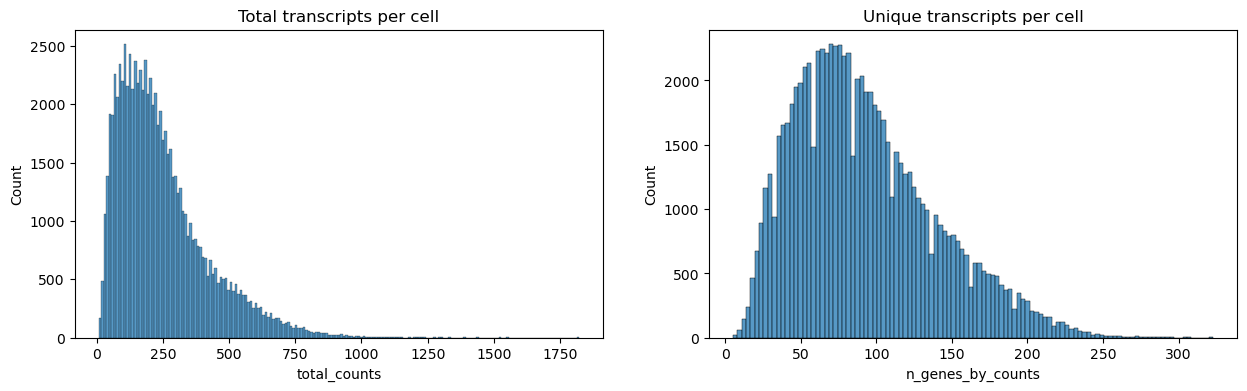

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata_subset.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata_subset.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


# axs[2].set_title("Area of segmented cells")
# sns.histplot(
#     adata_subset.obs["cell_area"],
#     kde=False,
#     ax=axs[2],
# )

# axs[3].set_title("Nucleus ratio")
# sns.histplot(
#     adata_subset.obs["nucleus_area"] / adata.obs["cell_area"],
#     kde=False,
#     ax=axs[3],
# )

In [47]:
sc.pp.filter_cells(adata_subset, min_counts=10)
sc.pp.filter_genes(adata_subset, min_cells=5)

In [48]:
adata_subset.layers["counts"] = adata_subset.X.copy()
sc.pp.normalize_total(adata_subset, inplace=True)
sc.pp.log1p(adata_subset)
sc.pp.pca(adata_subset)
sc.pp.neighbors(adata_subset)
sc.tl.umap(adata_subset)
sc.tl.leiden(adata_subset)
sc.tl.louvain(adata_subset)

2025-03-20 16:08:15.951209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-20 16:08:15.969036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-20 16:08:15.974446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 16:08:15.988518: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 16:08:52.780390: W tensorflow/compiler/tf2

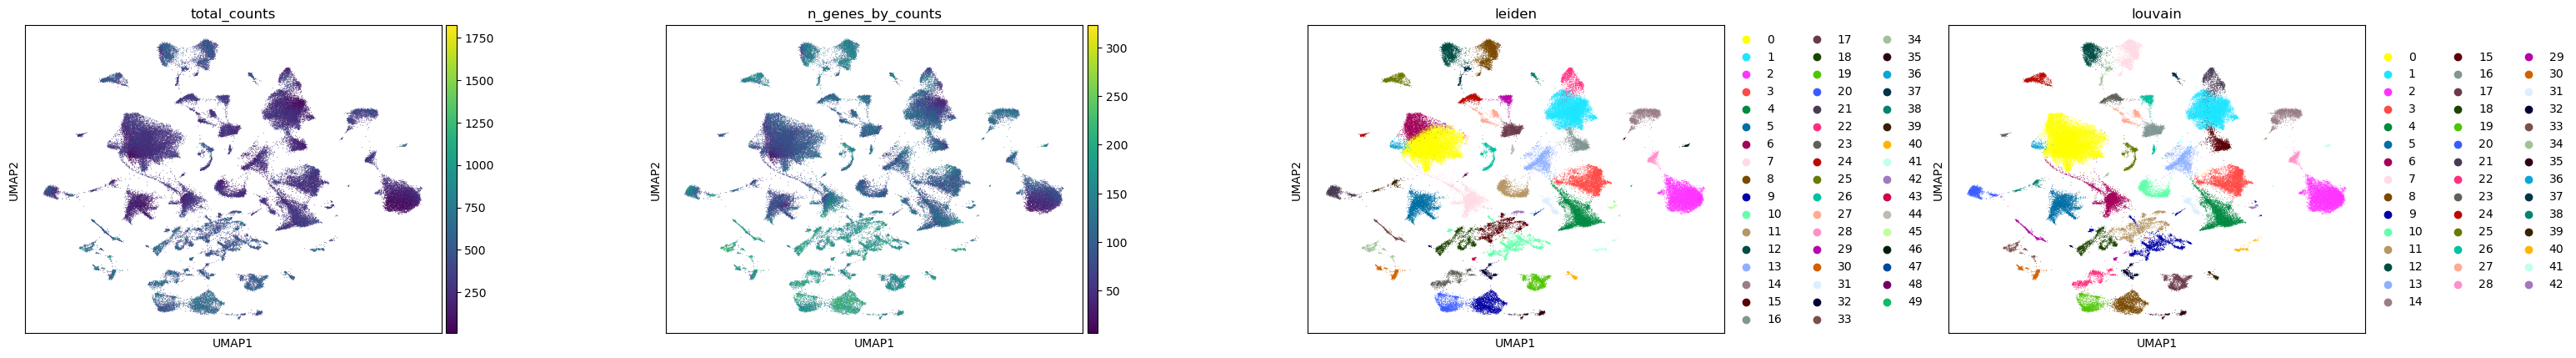

In [49]:
sc.pl.umap(
    adata_subset,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden","louvain"
    ],
    wspace=0.4,
)

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


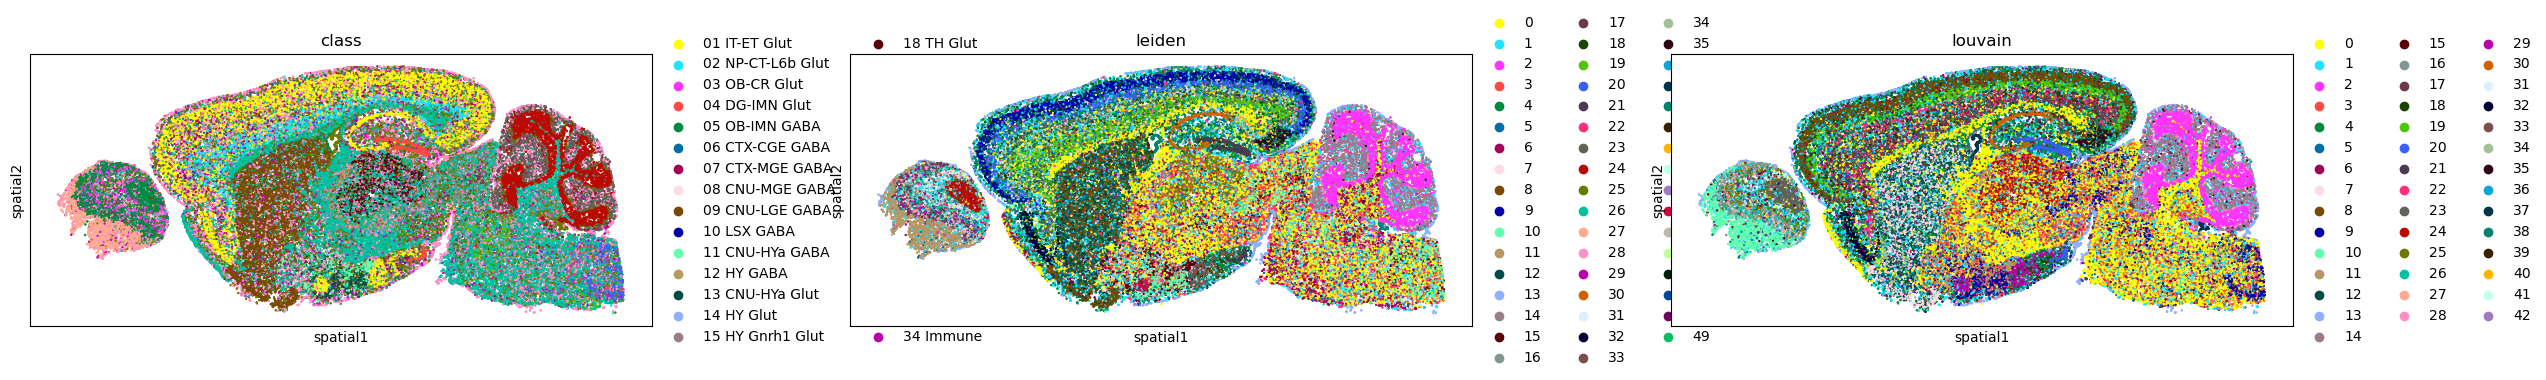

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(30, 30))  # Create subplots for two colors

sq.pl.spatial_scatter(
    adata_subset,
    library_id="spatial",
    shape=None,
    color=["class","leiden", "louvain"],
    wspace=0.4,
    fig=fig,  # Explicitly pass the figure object
    ax=axes   # Pass list of axes
)

plt.show()

In [54]:
#build neighborhood graph: 
sq.gr.spatial_neighbors(adata_subset, coord_type="generic", n_neighs = 10)

In [56]:
#now lets do a neighborhood enrichment: 
sq.gr.nhood_enrichment(adata_subset, cluster_key="class")

  0%|          | 0/1000 [00:00<?, ?/s]

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/gr/_nhood.py:202: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


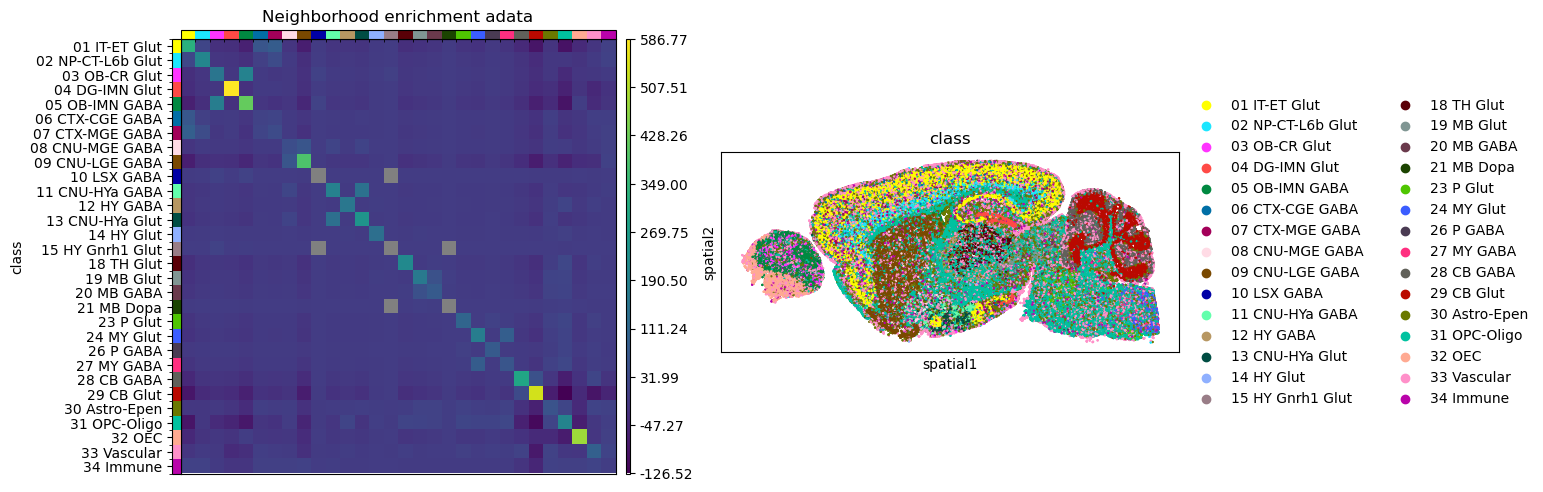

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata_subset,
    cluster_key="class",
    figsize=(8, 8),
    title="Neighborhood enrichment adata",
    ax=ax[0],
)
sq.pl.spatial_scatter(adata_subset, color="class", shape=None, size=2, ax=ax[1])

In [60]:
adata_subset.write_h5ad("/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/processed_data/merfish_sagital_brain.h5ad")

In [65]:
#adata_counts_only = ad.AnnData(adata_subset.X)
adata_subset.write_h5ad("/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/processed_data/merfish_sagital_brain_counts_only.h5ad")


In [62]:
del adata_subset.obs
del adata_subset.var
del adata_subset.uns
del adata_subset.obsm
del adata_subset.varm
del adata_subset.layers
del adata_subset.obsp

In [64]:
adata_subset

AnnData object with n_obs × n_vars = 81452 × 1122

In [66]:
#for some reason I cannot use find variable features when I convert over, 
# lets try a parquet file: 
from scipy import sparse
import pyarrow as pa
import pyarrow.parquet as pq

In [69]:
matrix = adata_subset.X
if sparse.issparse(matrix):
    matrix_dense = matrix.toarray()
else:
    matrix_dense = matrix

# Create a DataFrame
df = pd.DataFrame(matrix_dense, index=adata_subset.obs.index, columns=adata_subset.var.index)

# Convert DataFrame to an Arrow Table and save to Parquet
table = pa.Table.from_pandas(df)
pq.write_table(table, '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/processed_data/adata_matrix.parquet')

In [2]:
def geo_coord_index(adata,fraction =0.1,seed =0): 
    N =int(fraction * adata.X.shape[0])
    geo_coord_index = gs(adata.obsm['spatial'], N, seed=seed, replace=False)
    return geo_coord_index
def geo_transcriptomic_index(adata,fraction = 0.1,seed = 0):
    N =int(fraction * adata.X.shape[0])
    geo_transcriptomic_index = gs(adata.obsm['X_pca'], N, seed=seed, replace=False)
    return geo_transcriptomic_index

def geo_coord_shuffled_index(adata,fraction = 0.1, seed = 0):
    N =int(fraction * adata.X.shape[0])
    coords = adata.obsm['spatial']
    shuffled_coords = shuffle_coordinates(coords,seed = seed)
    geo_coord_shuffled_index = gs(shuffled_coords,N,seed = seed,replace = False)
    return geo_coord_shuffled_index
    
def scsampler_coord_index(adata,fraction = 0.1,seed = 0):
    res = scsampler(adata.obsm['spatial'], fraction=fraction, random_state=seed, copy=True,random_split = 16)
    scsampler_transcptomic_index = res[1]
    return sorted(list(scsampler_transcptomic_index))

def scsampler_transcriptomics_index(adata,fraction = 0.1,seed = 0):
    res = scsampler(adata.obsm['X_pca'], fraction=fraction, random_state=seed, copy=True,random_split = 16)
    return sorted(list(res[1]))


def scsampler_coord_shuffled_index(adata,fraction = 0.1,seed = 0):
    coords = adata.obsm['spatial']
    shuffled_coords = shuffle_coordinates(coords,seed = seed)
    res = scsampler(shuffled_coords,fraction = fraction,random_state = seed,copy = True,random_split = 16)
    return sorted(list(res[1]))

def uniform_index(adata,fraction = 0.1,seed = 0):
    np.random.seed(seed)
    num_cells = adata.n_obs
    sample_size = int(num_cells*fraction)
    sampled_indices = np.random.choice(adata.obs.index,size = sample_size,replace = False)
    return sorted(list(sampled_indices))



def shuffle_coordinates(coordinates,seed = 0):
    """Shuffles pairs of coordinates in a NumPy array.

    Args:
        coordinates (numpy.ndarray): An array of shape (N, 2) 
                                     where N is the number of coordinate pairs.

    Returns:
        numpy.ndarray: A new array with shuffled coordinate pairs.
    """
    rng = np.random.default_rng(seed = seed)
    shuffled_indices = rng.permutation(coordinates.shape[0])
    shuffled_coordinates = coordinates[shuffled_indices]
    return shuffled_coordinates



def leverage_index(adata,fraction = 0.1,score_column="gene_score",seed = 0):
    #print("running leverage sampling")
    np.random.seed(seed)

    if score_column not in adata.obs:
        raise ValueError(f"Column '{score_column}' not found in adata.obs")

    scores = adata.obs[score_column].values
    # scores = np.clip(scores, a_min=0, a_max=None)  # Ensure no negative values
    probabilities = scores / scores.sum()  # Normalize to get probabilities

    num_cells = adata.n_obs
    sample_size = int(num_cells * fraction)

    sampled_indices = np.random.choice(adata.n_obs, size=sample_size, replace=False, p=probabilities)
    return sorted(list(sampled_indices))

def create_leverage_index_dataframe(adata, fraction=0.1, num_seeds=10, start_seed=0):
    """
    Creates a DataFrame where each column contains the sorted indices from uniform_index
    for a different random seed.
    
    Args:
        adata: AnnData object to sample from
        fraction (float): Fraction of cells to sample
        num_seeds (int): Number of different seeds to use
        start_seed (int): Starting seed value
        
    Returns:
        pandas.DataFrame: DataFrame with columns named 'seed_{seed}' containing sorted indices
    """
    # Dictionary to store results
    results = {}
    
    # Run uniform_index for each seed
    for seed in range(start_seed, start_seed + num_seeds):
        column_name = f'seed_{seed}'
        indices = get_leverage_index(adata, fraction=fraction, seed=seed)
        results[column_name] = indices
    
    # Create DataFrame from results
    # Note: Columns might have different lengths, so we'll use a different approach
    df_dict = {}
    
    # Find the maximum length of any index list
    max_length = max(len(indices) for indices in results.values())
    
    # Pad shorter lists with NaN values
    for column_name, indices in results.items():
        # Pad with NaN if needed
        padded_indices = indices + [np.nan] * (max_length - len(indices))
        df_dict[column_name] = padded_indices
    
    # Create DataFrame
    result_df = pd.DataFrame(df_dict)
    
    return result_df

In [12]:
import os
from sklearn.decomposition import PCA
import numpy as np
import sys
from scipy.sparse import vstack
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,scale
from scipy.spatial import distance_matrix, distance
from sklearn.neighbors import KernelDensity
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sklearn.neighbors import BallTree
import time
import rdata
from scipy.sparse import csr_matrix,bsr_matrix,coo_matrix,issparse,lil_matrix,diags
from scipy.sparse.linalg import inv
import scipy as sp
from  scipy.ndimage import gaussian_filter
import igraph as ig
import glasbey
import warnings
import cairocffi as cairo
from sklearn.metrics import adjusted_rand_score,make_scorer
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn import preprocessing
import libpysal
from esda.losh import LOSH
from multiprocessing import Pool
from mclustpy import mclustpy
from sklearn.cluster import KMeans
import torch
#from GraphST import GraphST
import SEDR
#from GraphST.utils import clustering
from matplotlib.colors import ListedColormap
from esda import Moran
from libpysal.weights import KNN
from scsampler import scsampler 
from geosketch import gs
from scvalue import SCValue
from tqdm import tqdm
from fbpca import pca
from annoy import AnnoyIndex
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm

In [17]:
directory = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/processed_data"
adata = sc.read_h5ad(os.path.join(directory,"merfish_sagital_brain.h5ad"))


#re-run PCA for now: 
pca_model = PCA(n_components=20, svd_solver='randomized', random_state=2024)
pca_data = pca_model.fit_transform(adata.X)
adata.obsm['X_pca'] = pca_data

gene_scores_df = pd.read_csv('/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/processed_data/leverage_scores.csv')
adata.obs['gene_score'] = gene_scores_df['leverage_score'].values

parent_dir = '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index'

sub_dirs = {
    'uniform_index': uniform_index,
    'leverage_index':leverage_index,
    'geo_coord_shuffled_index': geo_coord_shuffled_index,
    'scsampler_coord_shuffled_index':scsampler_coord_shuffled_index,
    'geo_coord_index': geo_coord_index,
    'geo_transcriptomic_index': geo_transcriptomic_index,
    'scsampler_coord_index': scsampler_coord_index,
    'scsampler_transcriptomic_index': scsampler_transcriptomics_index
}




for seed in range(10):
    for fraction in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]:
        print(f"Running loop with seed:{seed}, and fraction: {fraction}")
        for sub_dir, index_function in sub_dirs.items():
        	result_lists = {f'seed_{seed}': []}  # Create an empty dictionary for results
        
        
        	# You need to define `adata` appropriately (not shown)
        	result = index_function(adata, fraction=fraction, seed=seed)
        	result_lists[f'seed_{seed}'] = result  # Store result in the dictionary under the appropriate seed key
        
        	# Create a DataFrame from the result lists
        	df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in result_lists.items()]))
        
        	# Save DataFrame to CSV in corresponding subdirectory
        	output_file_path = os.path.join(parent_dir, sub_dir, f'index_seed_{seed}_{fraction}.csv')
        	df.to_csv(output_file_path, index=False)
        
        	print(f'Results saved in {output_file_path}')

Running loop with seed:0, and fraction: 0.01
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index/uniform_index/index_seed_0_0.01.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index/leverage_index/index_seed_0_0.01.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index/geo_coord_shuffled_index/index_seed_0_0.01.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index/scsampler_coord_shuffled_index/index_seed_0_0.01.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index/geo_coord_index/index_seed_0_0.01.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index/geo_transcriptomic_index/index_seed_

In [18]:
for seed in range(10):
    for fraction in [0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        print(f"Running loop with seed:{seed}, and fraction: {fraction}")
        for sub_dir, index_function in sub_dirs.items():
        	result_lists = {f'seed_{seed}': []}  # Create an empty dictionary for results
        
        
        	# You need to define `adata` appropriately (not shown)
        	result = index_function(adata, fraction=fraction, seed=seed)
        	result_lists[f'seed_{seed}'] = result  # Store result in the dictionary under the appropriate seed key
        
        	# Create a DataFrame from the result lists
        	df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in result_lists.items()]))
        
        	# Save DataFrame to CSV in corresponding subdirectory
        	output_file_path = os.path.join(parent_dir, sub_dir, f'index_seed_{seed}_{fraction}.csv')
        	df.to_csv(output_file_path, index=False)
        
        	print(f'Results saved in {output_file_path}')

Running loop with seed:0, and fraction: 0.3
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index/uniform_index/index_seed_0_0.3.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index/leverage_index/index_seed_0_0.3.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index/geo_coord_shuffled_index/index_seed_0_0.3.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index/scsampler_coord_shuffled_index/index_seed_0_0.3.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index/geo_coord_index/index_seed_0_0.3.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index/geo_transcriptomic_index/index_seed_0_0.3.

In [53]:
import glob as glob
def combine_csv_files_by_fraction(input_dir, output_dir):
    # Ensure the output directory exists
    #os.makedirs(output_dir, exist_ok=True)
    
    # Get a list of all CSV files following the naming convention
    csv_files = glob.glob(os.path.join(input_dir, 'index_seed_*.csv'))
    
    # A dictionary to store DataFrames grouped by the fraction value
    fraction_file_dict = {}
    
    # Process each file
    for file_path in csv_files:
        # Extract the fraction from the file name
        file_name = os.path.basename(file_path)
        split_name = file_name.split('_')
        # Convert from string to float
        fraction = float(split_name[-1].replace('.csv', ''))
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Group by the fraction
        if fraction not in fraction_file_dict:
            fraction_file_dict[fraction] = [df]
        else:
            fraction_file_dict[fraction].append(df)
    
    # Write out the concatenated files by fraction
    for fraction, dfs in fraction_file_dict.items():
        # Concatenate all DataFrames for this fraction
        combined_df = pd.concat(dfs, ignore_index=False,axis=1)
        
        # Define the output file name
        output_file_name = f'index_{fraction:.2f}.csv'
        output_file_path = os.path.join(output_dir, output_file_name)
        
        # Save to a CSV file
        combined_df.to_csv(output_file_path, index=False)



In [61]:
# sub_dirs = {
#     'uniform_index': uniform_index,
#     'leverage_index':leverage_index,
#     'geo_coord_shuffled_index': geo_coord_shuffled_index,
#     'scsampler_coord_shuffled_index':scsampler_coord_shuffled_index,
#     'geo_coord_index': geo_coord_index,
#     'geo_transcriptomic_index': geo_transcriptomic_index,
#     'scsampler_coord_index': scsampler_coord_index,
#     'scsampler_transcriptomic_index': scsampler_transcriptomics_index
# }

parent_dir = '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index'

input_dir = os.path.join(parent_dir,'scsampler_transcriptomic_index/archive')
output_dir = os.path.join(parent_dir,'scsampler_transcriptomic_index')

combine_csv_files_by_fraction(input_dir, output_dir)

In [54]:
combine_csv_files_by_fraction(input_dir, output_dir)


In [60]:
glob.glob(os.path.join(input_dir, 'index_seed_*.csv'))

[]

In [59]:
csv_files = glob.glob(os.path.join(input_dir, 'index_seed_*.csv'))
    
    # A dictionary to store DataFrames grouped by the fraction value
fraction_file_dict = {}

# Process each file
for file_path in csv_files:
    # Extract the fraction from the file name
    file_name = os.path.basename(file_path)
    split_name = file_name.split('_')
    # Convert from string to float
    fraction = float(split_name[-1].replace('.csv', ''))
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Group by the fraction
    if fraction not in fraction_file_dict:
        fraction_file_dict[fraction] = [df]
    else:
        fraction_file_dict[fraction].append(df)

# Write out the concatenated files by fraction
for fraction, dfs in fraction_file_dict.items():
    # Concatenate all DataFrames for this fraction
    combined_df = pd.concat(dfs, ignore_index=False,axis=1)
    
    # Define the output file name
    output_file_name = f'index_{fraction:.2f}.csv'
    output_file_path = os.path.join(output_dir, output_file_name)
    
    # Save to a CSV file
    combined_df.to_csv(output_file_path, index=False)

TypeError: 'module' object is not callable. Did you mean: 'glob.glob(...)'?

In [56]:
output_file_path

'/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index/geo_coord_index/index_0.18.csv'

In [57]:
input_dir

'/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/index/scsampler_transcrptomic_index/archive'

In [58]:
csv_files

[]